In [1]:
import sys
sys.path.append('/mnt/antares_raid/home/oliver/nideep')
sys.path.append('/mnt/antares_raid/home/oliver/Scripts/autoencoder')
import numpy as np
import lmdb
import caffe
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import numpy as np
import lmdb
import argparse
from collections import defaultdict
import matplotlib.font_manager as font_manager
plt.rcParams['savefig.dpi'] = 1.5*plt.rcParams['savefig.dpi']


In [30]:
def forward_net(proto, model, lmdb_path = '/mnt/raid/ni/oliver/lmdb/MNIST_TEST_10000_rot_lmdb/', lmdb_rot_path =  '/mnt/raid/ni/oliver/lmdb/MNIST_TEST_10000_rot_ang_lmdb/' ):
    import itertools
    net = caffe.Net(proto, model, caffe.TEST)
    caffe.set_mode_cpu()
    lmdb_env = lmdb.open(lmdb_path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
    
    rot_lmdb_env = lmdb.open(lmdb_rot_path)
    rot_lmdb_txn = rot_lmdb_env.begin()
    rot_lmdb_cursor = rot_lmdb_txn.cursor()
    
    for I,R in itertools.izip(lmdb_cursor,rot_lmdb_cursor):
        key, value = I[0],I[1]
        key_rot, rot = R[0], R[1]
        datum = caffe.proto.caffe_pb2.Datum()
        datum.ParseFromString(value)
        label = int(datum.label)
        imag = caffe.io.datum_to_array(datum)
        image = imag.astype(np.uint8)    
        net.forward_all(data=np.asarray([image]))
        yield rot, imag.squeeze().T, 1*net.blobs['decode1neuron'].data[0,:].reshape(1*28, 28).T


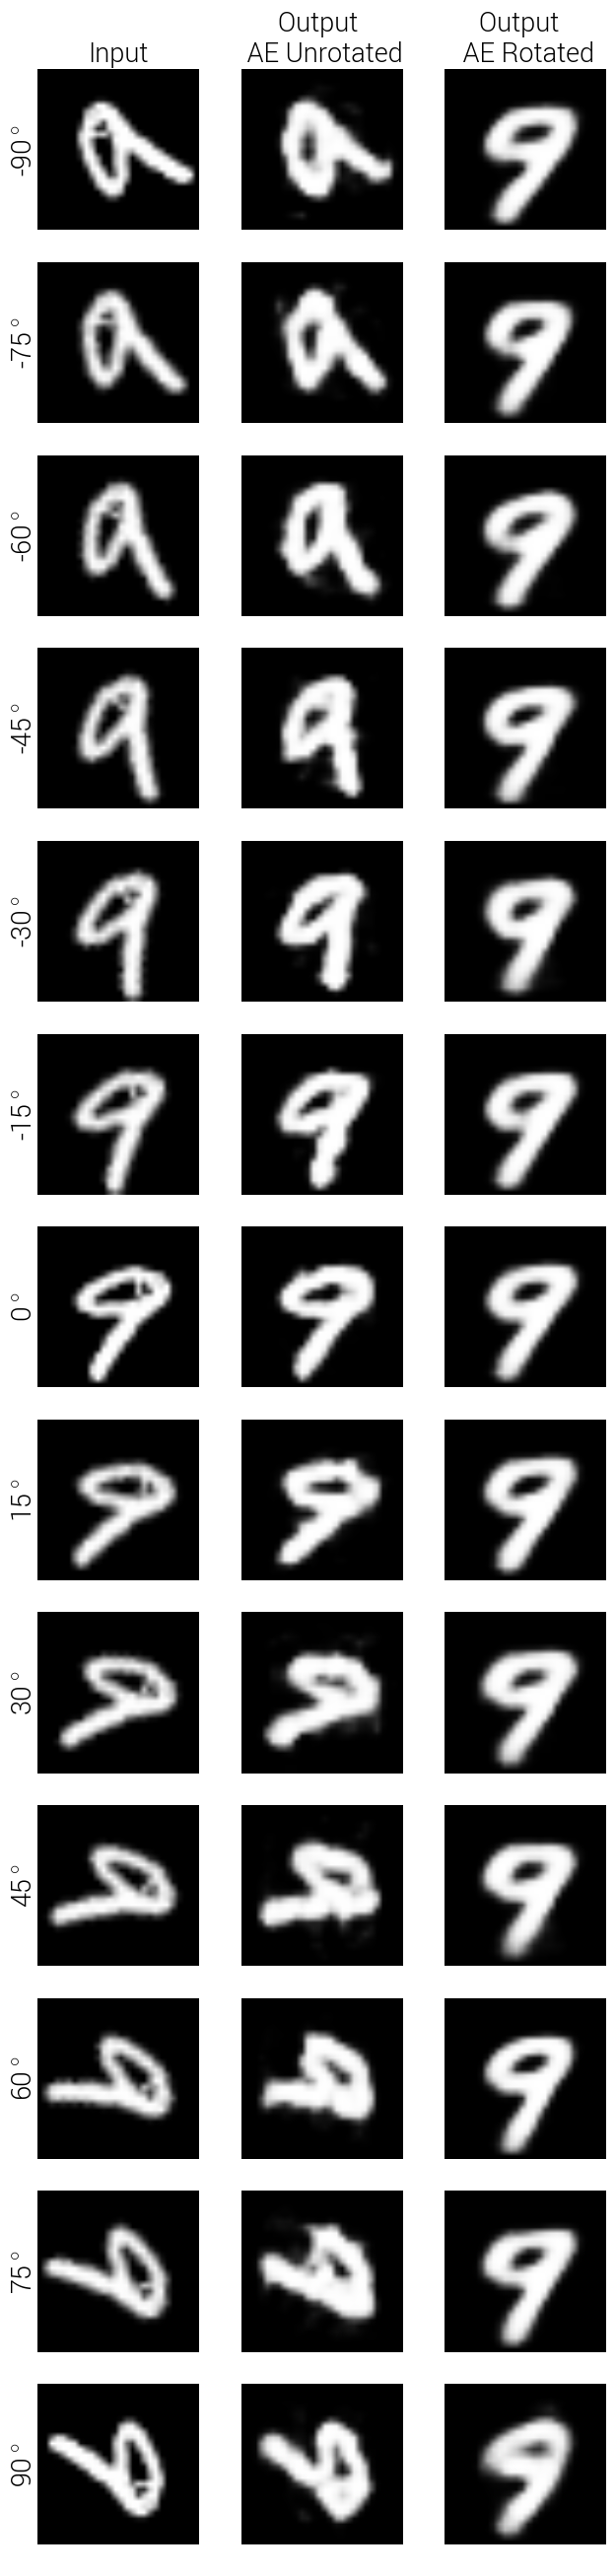

In [39]:
date = '0710'
snap = '390000'
res_dir = '/mnt/antares_raid/home/oliver/Scripts/Plots/Results/'
proto = '/mnt/antares_raid/home/oliver/Experiments/2008/AE_deploy_net.prototxt'
model = '/mnt/antares_raid/home/oliver/Experiments/{}/R/snapshots/_iter_{}.caffemodel'.format(date,snap)
R = forward_net(proto, model)
model = '/mnt/antares_raid/home/oliver/Experiments/{}/UR/snapshots/_iter_{}.caffemodel'.format(date,snap)
U = forward_net(proto, model)

path = '/mnt/antares_raid/home/oliver/roboto/Roboto-Light.ttf'
prop = font_manager.FontProperties(fname=path, size = 18)


def skip_number(U,R, n = 1):
    for j in range(n):
        if j < n-1:
            for i in range(13):
                _ , _,_ = U.next()
                _, _,_ = R.next()
        if j == n-1:
            for i in range(12):
                _ , _,_ = U.next()
                _, _,_ = R.next()
            
    return U,R
        
U,R = skip_number(U,R, 9)
    
n_im = 13
plt.figure(figsize = (7,30))
title = True
for i in range(n_im):
    if title:
        rot, _, outputU = U.next()
        rot, image,outputR = R.next()
        ax = plt.subplot(n_im,3,i*3 + 1 )
        plt.imshow(image, cmap='gray'); plt.axis('off')
        plt.title('Input',fontproperties=prop)
        plt.subplot(n_im,3,i*3 + 2 )
        plt.imshow(outputU, cmap='gray'); plt.axis('off')
        plt.title('Output \n AE Unrotated',fontproperties=prop)
        plt.subplot(n_im,3,i*3 + 3 )
        plt.imshow(outputR, cmap='gray'); plt.axis('off')
        plt.title('Output  \n AE Rotated',fontproperties=prop)
        title = False
    if not title:
        rot, _, outputU = U.next()
        rot, image,outputR = R.next()
        ax = plt.subplot(n_im,3,i*3 + 1 )
        ax.text(0, 0.5, rot + '$^\circ$',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical',
        multialignment='center',
        transform=ax.transAxes,fontproperties=prop)
        plt.imshow(image, cmap='gray'); plt.axis('off')
        plt.subplot(n_im,3,i*3 + 2 )
        plt.imshow(outputU, cmap='gray'); plt.axis('off')
        plt.subplot(n_im,3,i*3 + 3 )
        plt.imshow(outputR, cmap='gray'); plt.axis('off')
plt.savefig(res_dir + 'invariance_check.png',bbox_inches='tight')
plt.show()